# Probabilistic Roadmap


In this notebook you'll expand on previous random sampling exercises by creating a graph from the points and running A*.

1. Load the obstacle map data
2. Sample nodes (use KDTrees here)
3. Connect nodes (use KDTrees here)
4. Visualize graph
5. Define heuristic
6. Define search method
7. Execute and visualize

We'll load the data for you and provide a template for visualization.

In [1]:
# Again, ugly but we need the latest version of networkx!
# This sometimes fails for unknown reasons, please just 
# "reset and clear output" from the "Kernel" menu above 
# and try again!
import sys
!{sys.executable} -m pip install -I networkx==2.1
import pkg_resources
pkg_resources.require("networkx==2.1")
import networkx as nx

  Using cached https://files.pythonhosted.org/packages/f1/cd/7c8240007e9716b14679bc217a1baefa4432aa30394f7e2ec40a52b1a708/decorator-4.3.2-py2.py3-none-any.whl


In [2]:
nx.__version__ # should be 2.1

'2.1'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, LineString
from queue import PriorityQueue
import time

%matplotlib inline

In [4]:
plt.rcParams['figure.figsize'] = 12, 12

## Step 1 - Load Data

In [5]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [6]:
?np.loadtxt

## Step 2 - Sample Points


You may want to limit the z-axis values.

In [7]:
# TODO: sample points randomly
# then use KDTree to find nearest neighbor polygon
# and test for collision
# Import KDTree and numpy
from sklearn.neighbors import KDTree

# Generate some random 3-dimensional points
np.random.seed(0)
points = np.random.random((10, 3))  # 10 points in 3 dimensions
# Cast points into a KDTree data structure
tree = KDTree(points)              
# Extract indices of 3 closest points
# Note: need to cast search point as a list 
# and return 0th element only to get back list of indices
idxs = tree.query([points[0]], k=3, return_distance=False)[0] 


In [8]:
# extract polygons
def extract_polygons(data):

    polygons = []
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i, :]
        
        # TODO: Extract the 4 corners of each obstacle
        # 
        # NOTE: The order of the points needs to be counterclockwise
        # in order to work with the simple angle test
        # Also, `shapely` draws sequentially from point to point.
        #
        # If the area of the polygon in shapely is 0 
        # you've likely got a weird order.
        obstacle = [north - d_north, north + d_north, east - d_east, east + d_east]
        corners = [(obstacle[0], obstacle[2]), (obstacle[0], obstacle[3]), (obstacle[1], obstacle[3]), (obstacle[1], obstacle[2])]
        
        # TODO: Compute the height of the polygon
        height = alt + d_alt

        p = Polygon(corners)
        polygons.append((p, height))

    return polygons

polygons = extract_polygons(data)
print(len(polygons))

3845


In [9]:
# sample the 3d points
xmin = np.min(data[:, 0] - data[:, 3])
xmax = np.max(data[:, 0] + data[:, 3])

ymin = np.min(data[:, 1] - data[:, 4])
ymax = np.max(data[:, 1] + data[:, 4])

zmin = 0
zmax = 10
print("X")
print("min = {0}, max = {1}\n".format(xmin, xmax))

print("Y")
print("min = {0}, max = {1}\n".format(ymin, ymax))

print("Z")
print("min = {0}, max = {1}".format(zmin, zmax))
num_samples = 300

xvals = np.random.uniform(xmin, xmax, num_samples)
yvals = np.random.uniform(ymin, ymax, num_samples)
zvals = np.random.uniform(zmin, zmax, num_samples)

samples = np.array(list(zip(xvals, yvals, zvals)))

X
min = -315.2389, max = 604.7611

Y
min = -444.2315, max = 475.7685

Z
min = 0, max = 10


In [10]:
# collision check
def collides(polygons, point):   
    # TODO: Determine whether the point collides
    # with any obstacles.    
    for (p, height) in polygons:
        if p.contains(Point(point)) and height >= point[2]:
            return True
    return False

In [11]:
# non colliding points without kd_tree
t0 = time.time()
to_keep = []
for point in samples:
    if not collides(polygons, point):
        to_keep.append(point)
time_taken = time.time() - t0
print("Time taken {0} seconds ...".format(time_taken))

Time taken 15.602622032165527 seconds ...


In [12]:
# make kd_tree of samples
tree_polygon_centres = KDTree(data[:,:3])


In [13]:
idxs = tree_polygon_centres.query([samples[0]], k=3, return_distance=False)[0] 
print(idxs)

[668 704 667]


In [14]:
# extract polygon centres
print(samples[0])
# print(type(data))
print(data[:,:3])

[ -71.84773686 -277.5726152     0.62636003]
[[-310.2389   -439.2315     85.5     ]
 [-300.2389   -439.2315     85.5     ]
 [-290.2389   -439.2315     85.5     ]
 ...
 [ 257.8061    425.1645      1.75852 ]
 [ 293.9967    368.3391      3.557666]
 [ 281.5162    354.4156      4.999351]]


In [15]:
idxs = tree_polygon_centres.query([samples[0]], k=3, return_distance=False)[0]
# print(type(idxs))
# polygons = [polygons[i] for i in idxs]
# polygons

In [17]:
# non colliding points with kd_tree
t0 = time.time()
to_keep = []
 

for point in samples:
    idxs = tree_polygon_centres.query([point], k=3, return_distance=False)[0]
#     print(idxs)
    polygon_kd = [polygons[i] for i in idxs]
    if not collides(polygon_kd, point):
        to_keep.append(point)
time_taken = time.time() - t0
print("Time taken {0} seconds ...".format(time_taken))

Time taken 0.03507113456726074 seconds ...


In [18]:
type(to_keep[0])
tuple(to_keep[0])

(397.0560942794793, 281.23037132199727, 2.4190170420148482)

## Step 3 - Connect Nodes

Now we have to connect the nodes. There are many ways they might be done, it's completely up to you. The only restriction being no edge connecting two nodes may pass through an obstacle.

NOTE: You can use `LineString()` from the `shapely` library to create a line. Additionally, `shapely` geometry objects have a method `.crosses` which return `True` if the geometries cross paths, for instance your `LineString()` with an obstacle `Polygon()`!

In [19]:
# TODO: connect nodes
# Suggested method
    # 1) cast nodes into a graph called "g" using networkx
    # 2) write a method "can_connect()" that:
        # casts two points as a shapely LineString() object
        # tests for collision with a shapely Polygon() object
        # returns True if connection is possible, False otherwise
    # 3) write a method "create_graph()" that:
        # defines a networkx graph as g = Graph()
        # defines a tree = KDTree(nodes)
        # test for connectivity between each node and 
            # k of it's nearest neighbors
        # if nodes are connectable, add an edge to graph
    # Iterate through all candidate nodes!

In [20]:
def can_connect(point1, point2, polygons):
#     tree = KDTree(nodes)
    line = LineString([point1, point2])
    for (p, height) in polygons:
        if p.crosses(line) and height >= min(point1[2], point2[2]):
            return False
    return True

In [21]:
def create_graph(nodes, polygons):
    g = nx.Graph()
    tree_nodes = KDTree(nodes)
    for node in nodes:
        idxs = tree_nodes.query([node], k=10, return_distance=False)[0]
        node_kd = [nodes[i] for i in idxs]
        for node_neighbor in node_kd:
            if list(node) == list(node_neighbor):
                continue
            if can_connect(node, node_neighbor, polygons):
                dist = np.linalg.norm(node - node_neighbor)
                g.add_edge(tuple(node), tuple(node_neighbor), weight=dist)
    return g
                

In [22]:
g = create_graph(to_keep, polygons)

## Step 4 - Visualize Graph

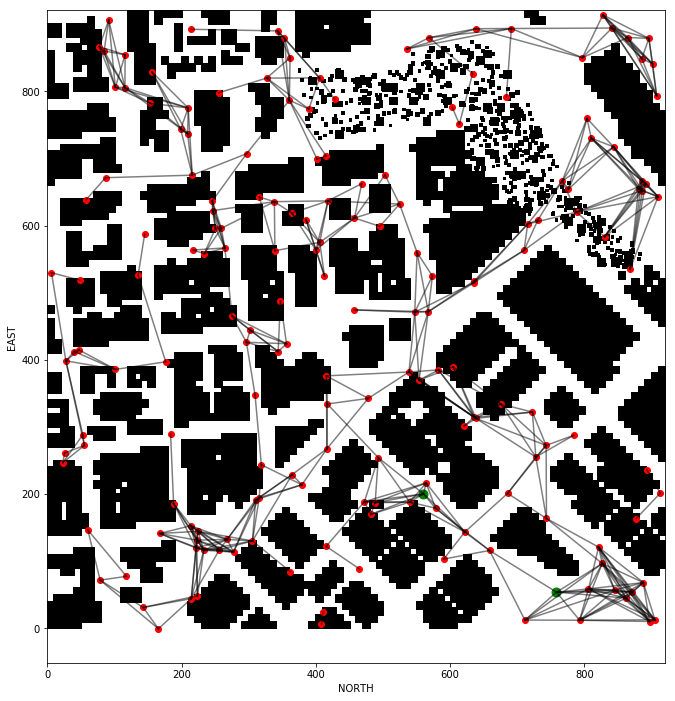

In [53]:
# Create a grid map of the world
from grid import create_grid
# This will create a grid map at 1 m above ground level
grid = create_grid(data, 1, 1)

fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# If you have a graph called "g" these plots should work
# Draw edges
for (n1, n2) in g.edges:
   plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black' , alpha=0.5)

# Draw all nodes connected or not in blue
# for n1 in to_keep:
#    plt.scatter(n1[1] - emin, n1[0] - nmin, c='blue')
    
# Draw connected nodes in red
for n1 in g.nodes:
   plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
start_ne = list(start)
goal_ne = list(goal)
plt.scatter(start_ne[1]- emin, start_ne[0]- nmin, c='green', s=20*2**2)
plt.scatter(goal_ne[1]- emin, goal_ne[0]- nmin, c='green', s=20*2**2)


plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

## Step 5 - Define Heuristic

In [41]:
def heuristic(n1, n2):
    # TODO: complete
    return np.linalg.norm(np.array(n2) - np.array(n1))

## Step 6 - Complete A*

In [29]:
def a_star_graph(graph, h, start, goal):
    path = []
    path_cost = 0
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_node = item[1]
        if current_node == start:
            current_cost = 0.0
        else:              
            current_cost = branch[current_node][0]
            
        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for nbr_n, data_dict in graph.adj[current_node].items():
                action_edge = (tuple(current_node), tuple(nbr_n))
                next_node = nbr_n
                action_cost = data_dict['weight']
                branch_cost = current_cost + action_cost
                queue_cost = branch_cost + h(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    branch[next_node] = (branch_cost, current_node, action_edge)
                    queue.put((queue_cost, next_node))
             
    if found:
        # retrace steps
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
    else:
        print('**********************')
        print('Failed to find a path!')
        print('**********************') 
    return path[::-1], path_cost


In [48]:
start = list(g.nodes)[10]
k = np.random.randint(len(g.nodes))
print(k, len(g.nodes))
goal = list(g.nodes)[k]
print(start, goal)

45 180
(-256.40005516869735, 319.2740791150758, 8.735568272907715) (-110.00379797063115, 121.07602995872446, 0.6560486720992564)


In [54]:
path, cost = a_star_graph(g, heuristic, start, goal)
print(len(path), cost)

Found a path.
4 247.55547026359966


## Step 7 - Visualize Path

In [55]:
path_pairs = zip(path[:-1], path[1:])


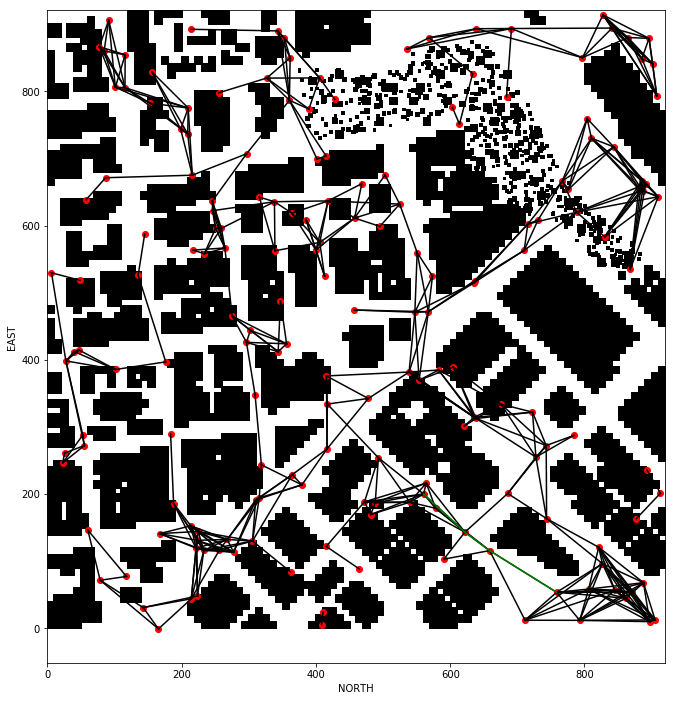

In [56]:
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# draw nodes
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    
# draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black')
    
# TODO: add code to visualize the path
path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'green')


plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

[solution](/notebooks/Probabilistic-Roadmap-Solution.ipynb)